#One Notebook to Rule Them All

Imports

In [125]:
import warnings
warnings.filterwarnings('ignore')

In [126]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3
import talib

/bin/bash: curl: command not found

bzip2: Compressed file ends unexpectedly;
	perhaps it is corrupted?  *Possible* reason follows.
bzip2: Inappropriate ioctl for device
	Input file = (stdin), output file = (stdout)

It is possible that the compressed file(s) have become corrupted.
You can use the -tvv option to test integrity of such files.

You can use the `bzip2recover' program to attempt to recover
data from undamaged sections of corrupted files.

tar: Child returned status 2
tar: Error is not recoverable: exiting now
/bin/bash: curl: command not found

bzip2: Compressed file ends unexpectedly;
	perhaps it is corrupted?  *Possible* reason follows.
bzip2: Inappropriate ioctl for device
	Input file = (stdin), output file = (stdout)

It is possible that the compressed file(s) have become corrupted.
You can use the -tvv option to test integrity of such files.

You can use the `bzip2recover' program to attempt to recover
data from undamaged sections of corrupted files.

tar: Child retur

In [127]:
from pathlib import Path
import requests
from io import BytesIO
from zipfile import ZipFile, BadZipFile

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer
import joblib

from time import time
from io import StringIO
import sys, os
from tqdm import tqdm

from itertools import product
from pathlib import Path

import statsmodels.api as sm

import lightgbm as lgb

from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

pd.set_option('display.expand_frame_repr', False)

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')

idx = pd.IndexSlice

Read price data from Drive

In [129]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [130]:
prices = (pd.read_csv('./btc_v_d.csv', index_col=0,
                     parse_dates=True).loc['1789':'2022'].rename(columns=str.lower))
prices = prices.drop('volume', axis=1)
prices

,open,high,low,close
Date,,,,
2010-07-17,0.04951,0.04951,0.04951,0.04951
2010-07-18,0.04951,0.08585,0.04951,0.08584
2010-07-19,0.08584,0.09307,0.07723,0.08080
2010-07-20,0.08080,0.08181,0.07426,0.07474
2010-07-21,0.07474,0.07921,0.06634,0.07921
...,...,...,...,...
2022-02-05,40674.26000,41946.86000,40593.09000,41604.83000
2022-02-06,41604.83000,42192.68000,41141.23000,41611.97000
2022-02-07,41599.58000,44526.25000,41513.75000,44096.97000


Calculate lagging returns

In [131]:
intervals = [1, 5, 10, 21, 63]

In [132]:
returns = []
for t in intervals:
    returns.append(prices['close'].pct_change(t).to_frame(f'ret_{t}'))
returns = pd.concat(returns, axis=1)

returns.head(20)

,ret_1,ret_5,ret_10,ret_21,ret_63
Date,,,,,
2010-07-17,NaN,NaN,NaN,NaN,NaN
2010-07-18,0.733791,NaN,NaN,NaN,NaN
2010-07-19,-0.058714,NaN,NaN,NaN,NaN
2010-07-20,-0.075000,NaN,NaN,NaN,NaN
2010-07-21,0.059807,NaN,NaN,NaN,NaN
2010-07-22,-0.362454,0.019996,NaN,NaN,NaN
2010-07-23,0.240000,-0.270503,NaN,NaN,NaN
2010-07-24,-0.129032,-0.325000,NaN,NaN,NaN
2010-07-25,-0.074074,-0.324324,NaN,NaN,NaN


In [133]:
max_ret = returns.groupby(level='Date').max()
percentiles = [0.001, .005, .01, .025, .05, .1]
percentiles += [1-p for p in percentiles]
max_ret.describe(percentiles=sorted(percentiles)[6:])

,ret_1,ret_5,ret_10,ret_21,ret_63
count,4225.000000,4221.000000,4216.000000,4205.000000,4163.000000
mean,0.005349,0.025077,0.052869,0.122160,0.541776
std,0.078474,0.159017,0.245952,0.438153,1.974266
min,-0.572057,-0.698386,-0.807906,-0.881174,-0.847093
50%,0.001685,0.010000,0.017202,0.034149,0.153920
90%,0.051666,0.147118,0.243939,0.446013,1.331509
95%,0.080218,0.220434,0.371704,0.696903,2.628017
97.5%,0.117756,0.309428,0.643417,1.226929,3.772259
99%,0.175170,0.527490,0.974296,2.324894,7.993609
99.5%,0.248706,0.739834,1.178879,2.861354,12.692660


Remove outliers

In [134]:
quantiles = max_ret.quantile(.95)
to_drop = []
for ret, q in quantiles.items():
    to_drop.extend(max_ret[max_ret[ret] > q].index.tolist()) 

to_drop = pd.Series(to_drop).value_counts()
to_drop = to_drop[to_drop > 1].index.tolist()
len(to_drop)

269

In [135]:
prices = prices.drop(to_drop)
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3957 entries, 2010-07-17 to 2022-02-09
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    3957 non-null   float64
 1   high    3957 non-null   float64
 2   low     3957 non-null   float64
 3   close   3957 non-null   float64
dtypes: float64(4)
memory usage: 154.6 KB


Calculate returns again

In [136]:
returns = []
by_sym = prices.close
for t in intervals:
    ret = by_sym.pct_change(t)
    rel_perc = pd.qcut(ret, q=20, labels=False, duplicates='drop')
    returns.extend([ret.to_frame(f'ret_{t}'), rel_perc.to_frame(f'ret_rel_perc_{t}')])
returns = pd.concat(returns, axis=1)

returns

,ret_1,ret_rel_perc_1,ret_5,ret_rel_perc_5,ret_10,ret_rel_perc_10,ret_21,ret_rel_perc_21,ret_63,ret_rel_perc_63
Date,,,,,,,,,,
2010-07-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-18,0.733791,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-19,-0.058714,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-20,-0.075000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-21,0.059807,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-02-05,0.022879,15.0,0.082566,16.0,0.138753,16.0,-0.038239,6.0,-0.156143,4.0
2022-02-06,0.000172,9.0,0.074754,15.0,0.133001,16.0,-0.036922,6.0,-0.156599,4.0
2022-02-07,0.059718,18.0,0.190623,19.0,0.170702,17.0,0.047583,10.0,-0.133508,4.0


Calculate some technical indicators

In [137]:
ppo = talib.PPO(prices.close).to_frame('PPO')
natr = talib.NATR(prices.high, prices.low, prices.close).to_frame('NATR')
rsi = talib.RSI(prices.close).to_frame('RSI')
u, m, l = talib.BBANDS(prices.close)
bbands = pd.DataFrame({'u': u, 'm': m, 'l': l})

data = pd.concat([prices, returns, ppo, natr, rsi, bbands], axis=1)
data['bbl'] = data.close.div(data.l)
data['bbu'] = data.u.div(data.close)
data = data.drop(['u', 'm', 'l'], axis=1)
print(data.bbu.corr(data.bbl, method='spearman'))
data

0.05226636383963079


,open,high,low,close,ret_1,ret_rel_perc_1,ret_5,ret_rel_perc_5,ret_10,ret_rel_perc_10,ret_21,ret_rel_perc_21,ret_63,ret_rel_perc_63,PPO,NATR,RSI,bbl,bbu
Date,,,,,,,,,,,,,,,,,,,
2010-07-17,0.04951,0.04951,0.04951,0.04951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-18,0.04951,0.08585,0.04951,0.08584,0.733791,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-19,0.08584,0.09307,0.07723,0.08080,-0.058714,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-20,0.08080,0.08181,0.07426,0.07474,-0.075000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-21,0.07474,0.07921,0.06634,0.07921,0.059807,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.633084,1.256617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-05,40674.26000,41946.86000,40593.09000,41604.83000,0.022879,15.0,0.082566,16.0,0.138753,16.0,-0.038239,6.0,-0.156143,4.0,-3.537523,5.001997,56.331060,1.180875,1.027811
2022-02-06,41604.83000,42192.68000,41141.23000,41611.97000,0.000172,9.0,0.074754,15.0,0.133001,16.0,-0.036922,6.0,-0.156599,4.0,-2.416214,4.824400,56.355121,1.178645,1.053709
2022-02-07,41599.58000,44526.25000,41513.75000,44096.97000,0.059718,18.0,0.190623,19.0,0.170702,17.0,0.047583,10.0,-0.133508,4.0,-0.841630,4.715316,63.825648,1.212944,1.034550


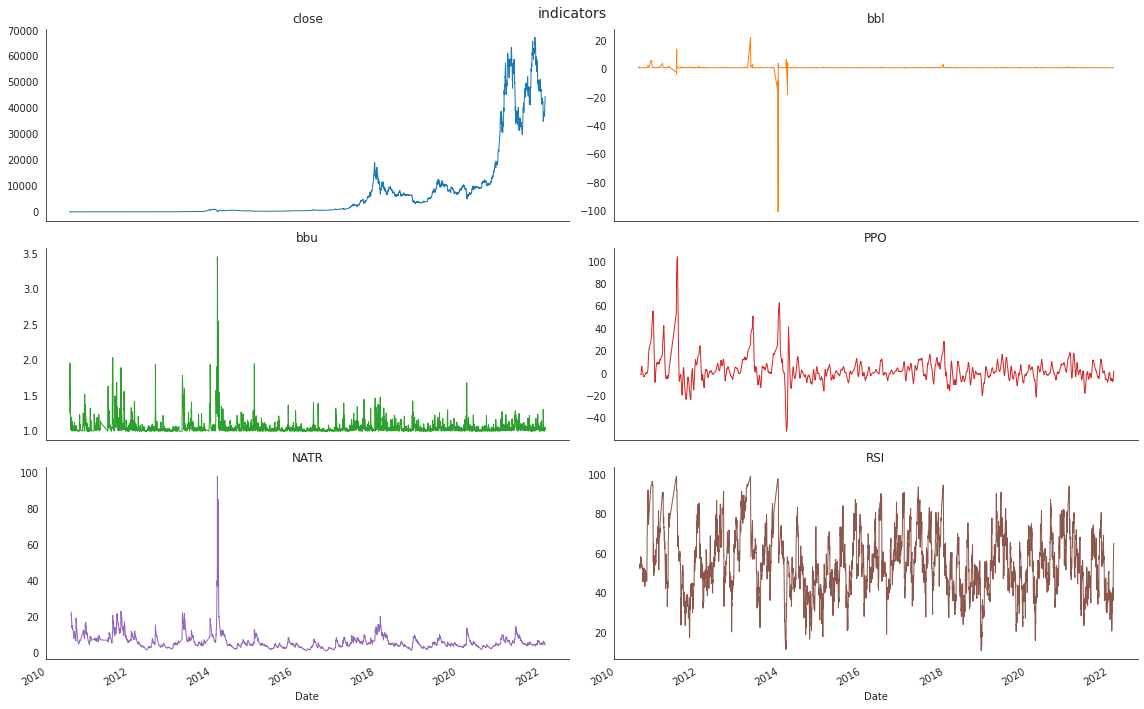

In [138]:
indicators = ['close', 'bbl', 'bbu', 'PPO', 'NATR', 'RSI']
data[indicators].plot(lw=1, subplots=True, figsize=(16, 10), title=indicators, layout=(3, 2), legend=False)
plt.suptitle('indicators', fontsize=14)
sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=.95)

In [139]:
dates = data.index.get_level_values('Date')
data['weekday'] = dates.weekday
data['month'] = dates.month
data['year'] = dates.year

outcomes = []
for t in intervals:
    k = f'fwd_ret_{t:02}'
    outcomes.append(k)
    data[k] = data[f'ret_{t}'].shift(-t)
# data.info(null_counts=True)

data.head()

,open,high,low,close,ret_1,ret_rel_perc_1,ret_5,ret_rel_perc_5,ret_10,ret_rel_perc_10,...,bbl,bbu,weekday,month,year,fwd_ret_01,fwd_ret_05,fwd_ret_10,fwd_ret_21,fwd_ret_63
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-17,0.04951,0.04951,0.04951,0.04951,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5,7,2010,0.733791,0.019996,0.211876,0.230055,0.254292
2010-07-18,0.04951,0.08585,0.04951,0.08584,0.733791,19.0,NaN,NaN,NaN,NaN,...,NaN,NaN,6,7,2010,-0.058714,-0.270503,-0.313840,-0.184529,-0.270154
2010-07-19,0.08584,0.09307,0.07723,0.08080,-0.058714,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0,7,2010,-0.075000,-0.325000,-0.224010,-0.170792,-0.230198
2010-07-20,0.08080,0.08181,0.07426,0.07474,-0.075000,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1,7,2010,0.059807,-0.324324,-0.092186,-0.063420,-0.166310
2010-07-21,0.07474,0.07921,0.06634,0.07921,0.059807,18.0,NaN,NaN,NaN,NaN,...,1.633084,1.256617,2,7,2010,-0.362454,-0.293019,-0.228633,-0.185709,-0.214746


In [140]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the inde contains level 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values('Date').unique()
        days = sorted(unique_dates, reverse=True)

        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[['Date']]
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[(dates.Date > days[train_start])
                              & (dates.Date <= days[train_end])].index
            test_idx = dates[(dates.Date > days[test_start])
                             & (dates.Date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

cv = MultipleTimeSeriesCV(n_splits=36,
                          test_period_length=21,
                          lookahead=5,
                          train_period_length=2 * 252)

In [141]:
for i, (train_idx, test_idx) in enumerate(cv.split(X=data)):
    train = data.iloc[train_idx]
    train_dates = train.index.get_level_values('Date')
    test = data.iloc[test_idx]
    test_dates = test.index.get_level_values('Date')
    df = train.reset_index().append(test.reset_index())
    n = len(df)
    assert n== len(df.drop_duplicates())
    msg = f'Training: {train_dates.min().date()}-{train_dates.max().date()} '
    msg += f' ({train.shape[0]} days) | '
    msg += f'Test: {test_dates.min().date()}-{test_dates.max().date()} '
    msg += f'({test.shape[0]} days)'
    print(msg)
    if i == 3:
        break

Training: 2020-08-20-2022-01-15  (508 days) | Test: 2022-01-20-2022-02-09 (21 days)
Training: 2020-07-30-2021-12-25  (508 days) | Test: 2021-12-30-2022-01-19 (21 days)
Training: 2020-07-09-2021-12-04  (508 days) | Test: 2021-12-09-2021-12-29 (21 days)
Training: 2020-06-18-2021-11-13  (508 days) | Test: 2021-11-18-2021-12-08 (21 days)


In [142]:
cv_data = data.loc['2011':'2022']
linear_regression = LinearRegression()

labels = sorted(cv_data.filter(like='fwd').columns)
features = cv_data.columns.difference(labels).tolist()

YEAR = 252 #252 business days in a year

lookaheads = [1, 5, 10, 21]
train_lengths = [5 * YEAR, 3 * YEAR, YEAR, 126, 63]
test_lengths = [5, 21]

test_params = list(product(lookaheads, train_lengths, test_lengths))

lr_metrics = []
for lookahead, train_length, test_length in tqdm(test_params):
    label = f'fwd_ret_{lookahead:02}'
    df = cv_data.loc[:, features + [label]].dropna()
    X, y = df.drop(label, axis=1), df[label]

    n_splits = int(2 * YEAR / test_length)
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              test_period_length=test_length,
                              lookahead=lookahead,
                              train_period_length=train_length)

    ic, preds, success = [], [], []
    for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        linear_regression.fit(X_train, y_train)
        y_pred = linear_regression.predict(X_test)
        preds.append(y_test.to_frame('y_true').assign(y_pred=y_pred))
        ic.append(spearmanr(y_test, y_pred)[0])
        success.append(np.sum(y_test * y_pred > 0) / y_test.size)
    preds = pd.concat(preds)
    lr_metrics.append([
        lookahead, train_length, test_length,
        np.mean(ic),
        spearmanr(preds.y_true, preds.y_pred)[0],
        np.mean(success)
    ])

columns = ['lookahead', 'train_length', 'test_length', 'ic_by_day', 'ic', 'avg_success']
lr_metrics = pd.DataFrame(lr_metrics, columns=columns)

100%|██████████| 40/40 [00:12<00:00,  3.10it/s]


In [143]:
lr_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lookahead     40 non-null     int64  
 1   train_length  40 non-null     int64  
 2   test_length   40 non-null     int64  
 3   ic_by_day     40 non-null     float64
 4   ic            40 non-null     float64
 5   avg_success   40 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 2.0 KB


In [105]:
lr_metrics_long = pd.concat([(lr_metrics.drop('ic', axis=1)
                              .rename(columns={'ic_by_day': 'ic'})
                              .assign(Measured='By Interval')),
                             lr_metrics.drop('ic_by_day', axis=1)
                             .assign(Measured='Overall')])
lr_metrics_long.columns=['Lookahead', 'Train Length', 'Test Length', 'IC', 'Avg. Success Rate', 'Measure']
lr_metrics_long

,Lookahead,Train Length,Test Length,IC,Avg. Success Rate,Measure
0,1,1260,5,0.080000,0.488000,By Interval
1,1,1260,21,0.024838,0.498016,By Interval
2,1,756,5,0.118000,0.512000,By Interval
3,1,756,21,0.025487,0.507937,By Interval
4,1,252,5,0.139000,0.542000,By Interval
...,...,...,...,...,...,...
35,21,252,21,0.111958,0.561508,Overall
36,21,126,5,-0.048215,0.482000,Overall
37,21,126,21,-0.087213,0.472222,Overall
38,21,63,5,-0.123109,0.448000,Overall


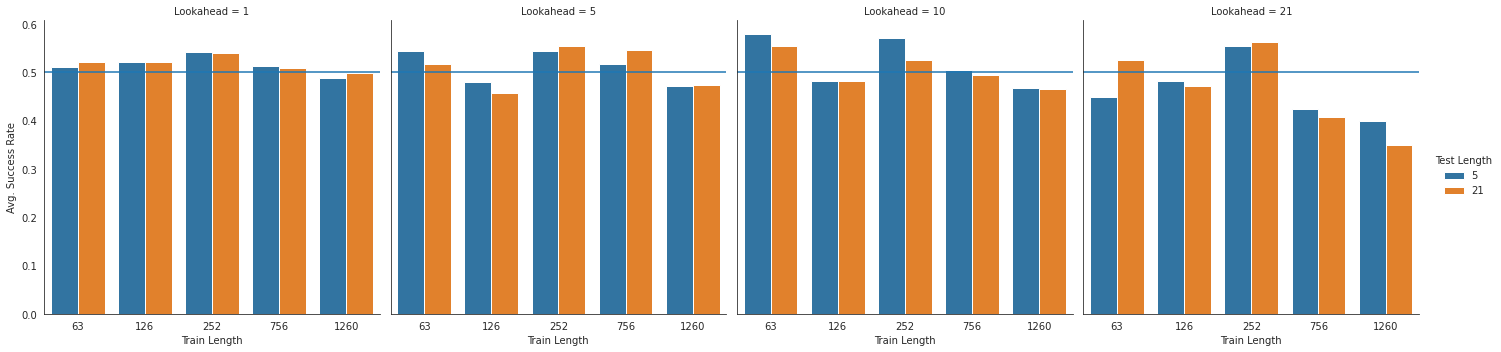

In [106]:
plot = sns.catplot(x='Train Length',
            y='Avg. Success Rate',
            hue='Test Length',
            col='Lookahead',
            data=lr_metrics_long,
            kind='bar')

for ax_arr in plot.axes:
    for ax in ax_arr:
        ax.axhline(0.5)
plot

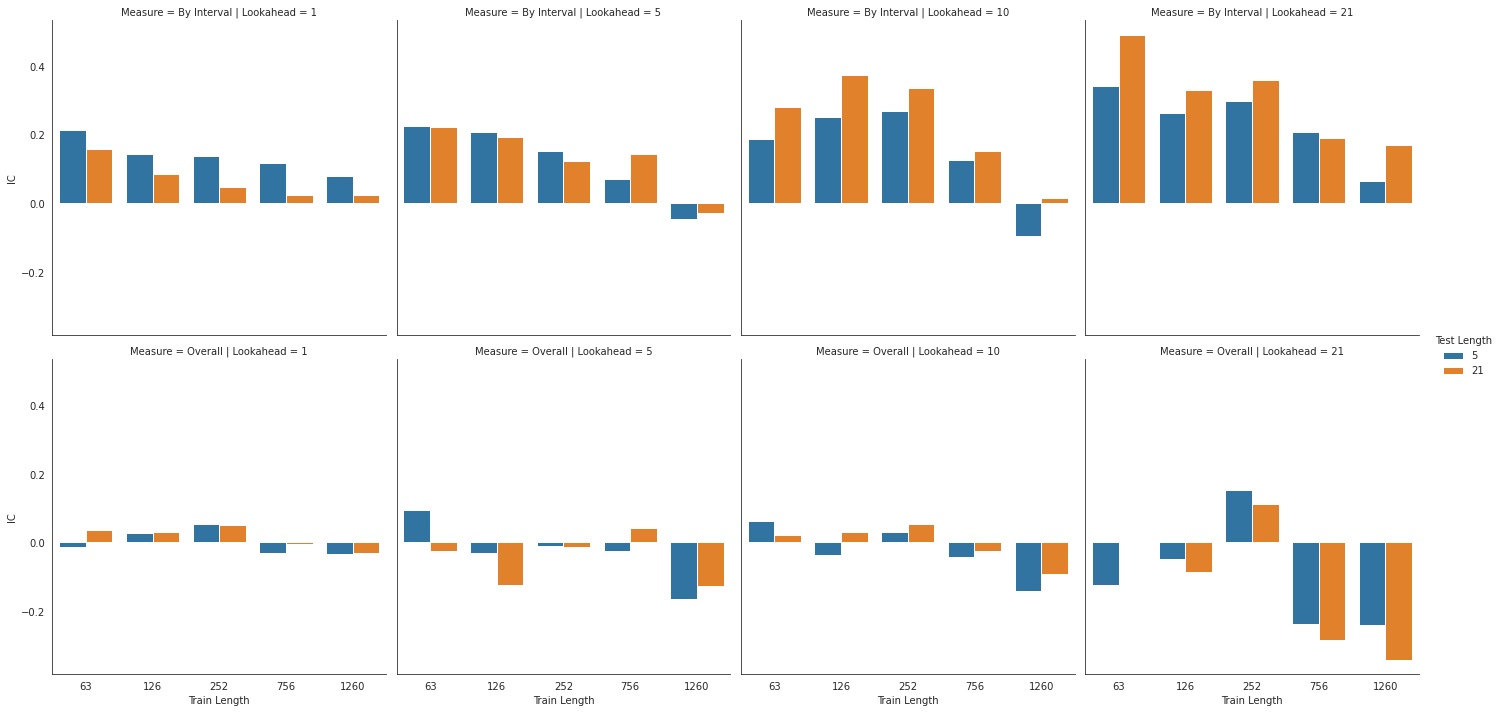

In [107]:
sns.catplot(x='Train Length',
            y='IC',
            hue='Test Length',
            col='Lookahead',
            row='Measure',
            data=lr_metrics_long,
            kind='bar')

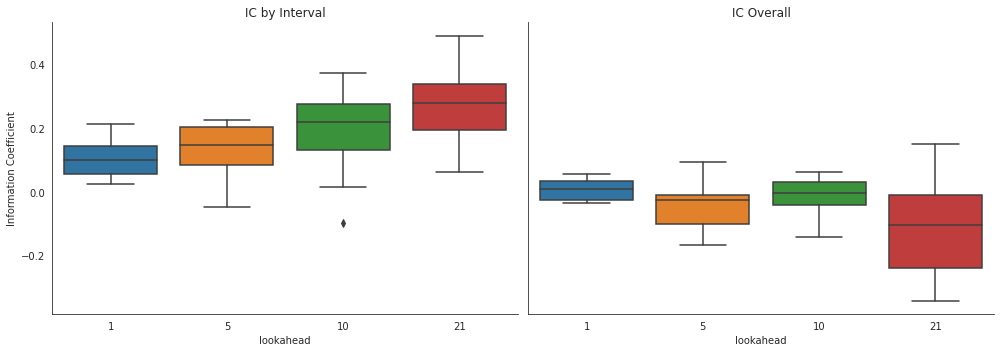

In [144]:
fig, axes =plt.subplots(ncols=2, figsize=(14,5), sharey=True)
sns.boxplot(x='lookahead', y='ic_by_day',data=lr_metrics, ax=axes[0])
axes[0].set_title('IC by Interval')
sns.boxplot(x='lookahead', y='ic',data=lr_metrics, ax=axes[1])
axes[1].set_title('IC Overall')
axes[0].set_ylabel('Information Coefficient')
axes[1].set_ylabel('')
sns.despine()
fig.tight_layout()

In [109]:
(lr_metrics.groupby('lookahead', group_keys=False)
 .apply(lambda x: x.nlargest(3, 'ic')))

,lookahead,train_length,test_length,ic_by_day,ic,avg_success
4,1,252,5,0.139000,0.054996,0.542000
5,1,252,21,0.048106,0.050407,0.539683
9,1,63,21,0.158550,0.036116,0.521825
18,5,63,5,0.225000,0.093529,0.544000
13,5,756,21,0.142803,0.042960,0.545635
14,5,252,5,0.152000,-0.008960,0.544000
28,10,63,5,0.188000,0.061719,0.578000
25,10,252,21,0.335281,0.054685,0.525794
27,10,126,21,0.374405,0.030962,0.482143
34,21,252,5,0.297000,0.152164,0.554000


In [110]:
results_path = Path('results', 'return_predictions')
if not results_path.exists():
    results_path.mkdir(parents=True)
    
lr_metrics.to_csv(results_path / 'lin_reg_performance.csv', index=False)

In [111]:
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

In [112]:
base_params = dict(
                    boosting_type='rf',
                   objective='regression',
                   bagging_freq=1)

In [113]:
bagging_fraction_opts = [.5, .75, .95]
feature_fraction_opts = [.75, .95]
min_data_in_leaf_opts = [10, 25, 50]

In [114]:
cv_params = list(product(bagging_fraction_opts,
                         feature_fraction_opts,
                         min_data_in_leaf_opts))
n_cv_params = len(cv_params)
n_cv_params

18

In [115]:
sample_proportion = .5
sample_size = int(sample_proportion * n_cv_params)

cv_param_sample = np.random.choice(list(range(n_cv_params)), 
                                     size=int(sample_size), 
                                     replace=False)
cv_params_ = [cv_params[i] for i in cv_param_sample]
print('# CV parameters:', len(cv_params_))

# CV parameters: 9


In [116]:
num_iterations = [25] + list(range(50, 501, 25))
num_boost_round = num_iterations[-1]

train_lengths = [5 * YEAR, 3 * YEAR, YEAR, 126, 63]
test_lengths = [5, 21]

test_params = list(product(train_lengths, test_lengths))
n_test_params = len(test_params)

sample_proportion = 1.0
sample_size = int(sample_proportion * n_test_params)

test_param_sample = np.random.choice(list(range(n_test_params)), 
                                     size=int(sample_size), 
                                     replace=False)
test_params_ = [test_params[i] for i in test_param_sample]
print('Train configs:', len(test_params_))
print('CV Iterations:', len(cv_params_) * len(test_params_))

Train configs: 10
CV Iterations: 90


In [117]:
rf_clf = RandomForestClassifier(oob_score=True, 
                                n_jobs=-1,
                                random_state=42, 
                                verbose=1)

adaBoost_clf = AdaBoostClassifier(random_state=42, )

cv = MultipleTimeSeriesCV(n_splits=36,
                          test_period_length=21,
                          lookahead=5,
                          train_period_length=2 * 252)

cv_score = cross_val_score(estimator=rf_clf,
                           X=pd.get_dummies(data.drop('fwd_ret_01', axis=1)),
                           y=(data['fwd_ret_01'] > 0).astype(int),
                           scoring='roc_auc',
                           cv=cv,
                           n_jobs=-1,
                           verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1

In [118]:
np.mean(cv_score[~np.isnan(cv_score)])

0.619479176026795

In [119]:
categoricals = ['year', 'weekday', 'month']
for feature in categoricals:
    data[feature] = pd.factorize(data[feature], sort=True)[0]

labels = sorted(cv_data.filter(like='fwd').columns)
features = cv_data.columns.difference(labels).tolist()

lookahead, train_length, test_length = 1, 252, 5

label_dict = dict(zip(lookaheads, labels))


In [155]:
loop_1 = set()
for lookahead, train_length, test_length in tqdm(test_params):
    # print(lookahead, train_length, test_length)
    loop_1.add((lookahead, train_length, test_length))

100%|██████████| 40/40 [00:00<00:00, 249660.95it/s]


In [ ]:
backup = data[:]

In [169]:

cv_store = Path(results_path / 'parameter_tuning.h5')

ic_cols = ['bagging_fraction',
           'feature_fraction',
           'min_data_in_leaf',
           't'] + [str(n) for n in num_iterations]

def format_time(t):
    """Return a formatted time string 'HH:MM:SS
    based on a numeric time() value"""
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:0>2.0f}:{m:0>2.0f}:{s:0>2.0f}'


# for lookahead, train_length, test_length in test_params:
#         n_splits = int(2 * YEAR / test_length)
#         print(f'Lookahead: {lookahead:2.0f} | Train: {train_length:3.0f} | '
#               f'Test: {test_length:2.0f} | Params: {len(cv_params_):3.0f}')

#         cv = MultipleTimeSeriesCV(n_splits=n_splits,
#                                   test_period_length=test_length,
#                                   train_period_length=train_length,
#                                   lookahead=lookahead)

#         label = label_dict[lookahead]
#         outcome_data = data.loc[:, features + [label]].dropna()

#         lgb_data = lgb.Dataset(data=outcome_data.drop(label, axis=1),
#                                label=outcome_data[label],
#                                categorical_feature=categoricals,
#                                free_raw_data=False)
                               
#         predictions, daily_ic, ic, feature_importance = [], [], [], []
#         key = f'{lookahead}/{train_length}/{test_length}'
#         T = 0
#         for p, (bagging_fraction, feature_fraction, min_data_in_leaf) in enumerate(cv_params_):
#             params = base_params.copy()
#             params.update(dict(bagging_fraction=bagging_fraction,
#                                feature_fraction=feature_fraction,
#                                min_data_in_leaf=min_data_in_leaf))

#             start = time()
#             cv_preds, nrounds = [], []
#             for i, (train_idx, test_idx) in enumerate(cv.split(X=outcome_data)):
#                 lgb_train = lgb_data.subset(train_idx.tolist()).construct()
#                 lgb_test = lgb_data.subset(test_idx.tolist()).construct()

#                 model = lgb.train(params=params,
#                                   train_set=lgb_train,
#                                   num_boost_round=num_boost_round,
#                                   verbose_eval=False)
#                 if i == 0:
#                     fi = get_fi(model).to_frame()
#                 else:
#                     fi[i] = get_fi(model)

#                 test_set = outcome_data.iloc[test_idx, :]
#                 X_test = test_set.loc[:, model.feature_name()]
#                 y_test = test_set.loc[:, label]
#                 y_pred = {str(n): model.predict(X_test, num_iteration=n)
#                           for n in num_iterations}
#                 cv_preds.append(y_test.to_frame(
#                     'y_test').assign(**y_pred).assign(i=i))
#                 nrounds.append(model.best_iteration)
#             feature_importance.append(fi.T.describe().T.assign(bagging_fraction=bagging_fraction,
#                                                                feature_fraction=feature_fraction,
#                                                                min_data_in_leaf=min_data_in_leaf))
#             cv_preds = pd.concat(cv_preds).assign(bagging_fraction=bagging_fraction,
#                                                   feature_fraction=feature_fraction,
#                                                   min_data_in_leaf=min_data_in_leaf)

#             predictions.append(cv_preds)

#             # success.append(np.sum(y_test * y_pred > 0) / y_test.size)

#             cv_ic = [spearmanr(cv_preds['y_test'], cv_preds[str(n)])[0]
#                   for n in num_iterations]

#             T += time() - start
#             ic.append([bagging_fraction, feature_fraction,
#                        min_data_in_leaf, lookahead] + cv_ic)

#             msg = f'{p:3.0f} | {format_time(T)} | '
#             msg += f'{bagging_fraction:3.0%} | {feature_fraction:3.0%} | {min_data_in_leaf:5,.0f} | '
#             msg += f'{max(cv_ic):6.2%} | {np.mean(cv_ic):6.2%} | {min(cv_ic):6.2%}'
#             print(msg)

#         m = pd.DataFrame(ic, columns=ic_cols)
#         m.to_hdf(cv_store, 'ic/' + key)
#         pd.concat(feature_importance).to_hdf(cv_store, 'fi/' + key)
#         pd.concat(predictions).to_hdf(cv_store, 'predictions/' + key)

,open
Date,
2010-07-17,0.04951
2010-07-18,0.04951
2010-07-19,0.08584
2010-07-20,0.08080
2010-07-21,0.07474


In [ ]:
id_vars = ['train_length',
           'test_length',
           'bagging_fraction',
           'feature_fraction',
           'min_data_in_leaf',
           't', 'date']

daily_ic, ic = [], []
for t in lookaheads:
    with pd.HDFStore(cv_store) as store:
        keys = [k[1:] for k in store.keys() if k.startswith(f'/fi/{t}')]
        for key in keys:
            train_length, test_length = key.split('/')[2:]
            print(train_length, test_length)
            k = f'{t}/{train_length}/{test_length}'
            cols = {'t': t,
                    'train_length': int(train_length),
                    'test_length': int(test_length)}

            ic.append(pd.melt(store['ic/' + k]
                              .assign(**cols),
                              id_vars=id_vars[:-1],
                              value_name='ic',
                              var_name='rounds')
                      .apply(pd.to_numeric))
                   
ic = pd.concat(ic, ignore_index=True)

1
5
10
21


ValueError: No objects to concatenate

In [ ]:
ic.groupby('t').apply(lambda x: x.nlargest(3, 'ic'))

train_length  test_length  bagging_fraction  feature_fraction  min_data_in_leaf   t  rounds        ic
t                                                                                                             
1  902            252            5              0.50              0.75                50   1      25  0.089472
   2702           252            5              0.50              0.75                50   1      25  0.089472
   906            252            5              0.50              0.95                50   1      25  0.082165
5  4154            63            5              0.95              0.75                25   5      50  0.131240
   4145            63            5              0.95              0.75                25   5      25  0.130214
   4208            63            5              0.95              0.75                25   5     200  0.128286
10 6147           252           21              0.75              0.75                10  10     100  0.185928
   6156           252           21              0.75              0.75                10  10     125  0.185055
   6165           252           21              0.75              0.75                10  10     150  0.182684
21 8100           252            5              0.75              0.75                10  21      25  0.254814
   8109           252            5              0.75              0.75                10  21      50  0.248583
   8118           252            5              0.75              0.75                10  21      75  0.248455

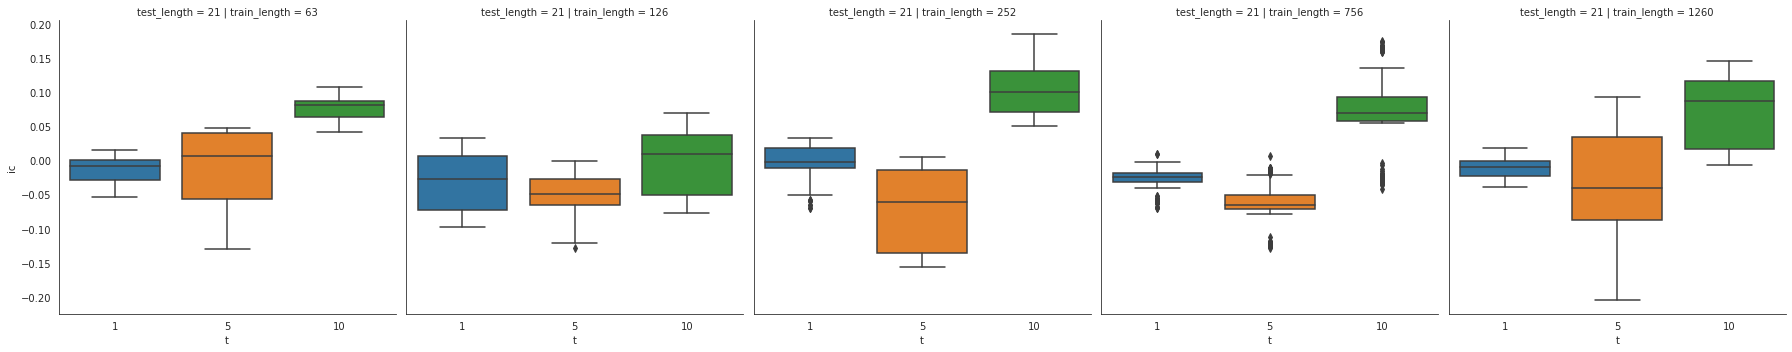

In [ ]:
g = sns.catplot(x='t',
                y='ic',
                col='train_length',
                row='test_length',
                data=ic[(ic.test_length == 21) & (ic.t < 21)],
                kind='box')

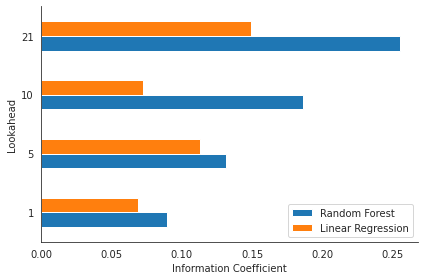

In [ ]:
with sns.axes_style("white"):
    ax = (ic.groupby('t').ic.max().to_frame('Random Forest')
     .join(lr_metrics.groupby('lookahead').ic.max().to_frame('Linear Regression')).plot.barh())
    ax.set_ylabel('Lookahead')
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    plt.tight_layout();